# BEE 4750 Lab 4: Simulation-Optimization

**Name**: Christine Swanson 

**ID**: cms549

> **Due Date**
>
> Friday, 11/17/23, 9:00pm

## Setup

The following code should go at the top of most Julia scripts; it will
load the local package environment and install any needed packages. You
will see this often and shouldn’t need to touch it.

In [1]:
import Pkg
Pkg.activate(".")
Pkg.instantiate()

  Activating project at `c:\Users\chris\Box\classwork\2023_Fall\BEE5750\labs\lab04-christinemswanson`


In [2]:
using Random # for random seeds
using Distributions # statistical distribution interface
using Roots # find zeros of functions
using Metaheuristics # search algorithms
using Plots # plotting

## Overview

In this lab, you will experiment with simulation-optimization with the
shallow lake problem. The goal of this experimentation is to get an
understanding of how to work with simulation-optimization methods and
the impact of some choices involved in using these methods.

Free free to delete some of the illustrative cells and code blocks in
your notebook as you go through and solve the lab problems…this might
help reduce some potential confusion while grading about what your
answer is.

## Introduction

Due to ongoing economic activity, a town emits phosphorous into a
shallow lake (with a concentration of $a_t$), which also receives
non-point source runoff (concentration $y_t$) from the surrounding area.
The concentration of the lake at time $t+1$ is given by
$$X_{t+1} = X_t + a_t + y_t + \frac{X_t^q}{1+X_t^q} - bX_t,$$

where:

| Parameter | Value                                                |
|:---------:|:-----------------------------------------------------|
|   $a_t$   | point-source phosphorous concentration from the town |
|   $y_t$   | non-point-source phosphorous concentration           |
|    $q$    | rate at which phosphorous is recycled from sediment  |
|    $b$    | rate at which phosphorous leaves the lake            |

and $X_0 = 0$, $y_t \sim LogNormal(\log(0.03), 0.25)$, $q=2.5$, and
$b=0.4$.

The goal of the optimization is to maximize the town’s average
phosphorous concentration releases (as a proxy of economic activity):
$\max \sum_{t=1}^T a_t / T$ over a 100-year period. We have decided
(initially) that an acceptable solution is one which will result in the
lake eutrophying no more than 10% of the time.

The non-point source samples can be sampled using the following code
block:

In [3]:
Random.seed!(1)

T = 100 # length of simualtion
n_samples = 1_000 # replace with number of samples if you experiment

P_distribution = LogNormal(log(0.03), 0.25)
y = rand(P_distribution, (T, n_samples)) # sample a T x n_samples matrix

100×1000 Matrix{Float64}:
 0.0294753  0.0459864  0.023513   …  0.0259183  0.0260934  0.0284652
 0.034263   0.0222782  0.0459188     0.0288482  0.0480454  0.0531018
 0.0245199  0.0296271  0.0445619     0.0246404  0.0250734  0.0304308
 0.055448   0.0312     0.0228208     0.0298609  0.0428105  0.0256198
 0.0401417  0.024978   0.0458244     0.0228935  0.0286062  0.0238694
 0.0320754  0.021759   0.0471452  …  0.0472771  0.0187508  0.0306753
 0.0464641  0.0416385  0.0246833     0.0382252  0.0288505  0.0226561
 0.0244027  0.0432707  0.0341214     0.0238988  0.0427204  0.0316143
 0.0231156  0.0279197  0.0217747     0.0231772  0.0335662  0.0324465
 0.0276303  0.0305858  0.0440326     0.0289394  0.0312328  0.0173388
 ⋮                                ⋱                        
 0.025665   0.0341366  0.0274747     0.0283546  0.0458031  0.0277959
 0.0405629  0.0421121  0.0252557     0.0450377  0.0284411  0.0206434
 0.0228445  0.0223746  0.0210942     0.0442834  0.0337672  0.0287835
 0.0252604  0.046

We write the lake model as a function:

In [4]:
# lake function model
# inputs:
#   a: vector of point-source releases (to be optimized)
#   y: randomly-sampled non-point sources
#   q: lake phosphorous recycling rate
#   b: phosphorous outflow rate
# 
# returns:
#   series of lake phosphorous concentrations
function lake(a, y, q, b, T)
    X = zeros(T+1, size(y, 2))
    # calculate states
    for t = 1:T
        X[t+1, :] = X[t, :] .+ a[t] .+ y[t, :] .+ (X[t, :].^q./(1 .+ X[t, :].^q)) .- b.*X[t, :]
    end
    return X
end

lake (generic function with 1 method)

However, this isn’t sufficient on its own! `Metaheuristics.jl` (and most
simulation-optimization packages) require the use of a *wrapper*
function, which accepts as inputs both parameters to be optimized (in
this case, point-source releases `a`) and parameters which will be fixed
(the others; see below for how to incorporate these into the syntax) and
returns the required information for the optimization procedure.

`Metaheuristics.jl` wants its optimizing wrapper function to return (in
order):

-   the objective(s) (in this case, the mean of `a`, $\sum_t a_t / T$),
-   a vector of the degrees to which the solution fails to achieve any
    inequality constraints (positive values indicate a larger failure,
    values below zero are considered acceptable)
-   a vector of the degrees to which the solution fails to achieve any
    equality constraints (only values of zero indicate success), which
    in this case is not relevant, so we just return `[0.0]`.

In [5]:
# function producing optimization outputs
# inputs:
#   a: vector of point-source releases (to be optimized)
#   y: randomly-sampled non-point sources
#   q: lake phosphorous recycling rate
#   b: phosphorous outflow rate
# 
# returns:
#   - objective: mean value of point-source releases
#   - inequality constraint failure vector
#   - equality constraint failure vector (in this case, always [0.0])
function lake_opt(a, y, q, b, T, Xcrit)
    X = lake(a, y, q, b, T)
    # calculate exceedance of critical value
    Pexceed = sum(X[T+1, :] .> Xcrit) / size(X, 2)
    failconst = [Pexceed - 0.1] # replace 0.1 if you experiment with the failure probability
    return mean(a), failconst, [0.0]
end

lake_opt (generic function with 1 method)

To optimize using DE (differential evolution), use the following syntax:

``` julia
results = optimize(f, bounds, DE(options=Options(f_calls_limit=max_evals)))
```

where `bounds` is a `Matrix` of lower bounds (first row) and upper
bounds (last row), and `max_evals` is an integer for the maximum number
of evaluations.

-   For example, to set bounds for all decision variables between 0 and
    0.5, you can use

``` julia
bounds = [zeros(T) 0.5ones(T)]'
```

-   Increasing `max_evals` can help you find a better solution, but at a
    larger computational expense.
-   You can use an anonymous function to fix values for non-optimized
    parameters, *e.g.*

``` julia
y = ...
q = ...
b = ...
T = ...
Xcrit = ...
results = optimize(a -> lake_opt(a, y, q, b, t, Xcrit), bounds, DE(options=Options(f_calls_limit=max_evals)))
```

Then to get the approximated minimum value:

``` julia
fx = minimum(result)
```

and the approximated minimizing value:

``` julia
x = minimizer(result)
```

The last piece is to get the critical value (to identify failures),
which we can do using `Roots.jl`, which finds zeros of functions:

In [6]:
# define a function whose zeros are the critical values
P_flux(x) = (x^q/(1+x^q)) - b*x
# use Roots.find_zero() to find the non-eutrophication and non-zero critical value; we know from visual inspection in class that this is bounded between 0.1 and 1.5.
Xcrit = find_zero(P_flux, (0.1, 1.5))

UndefVarError: UndefVarError: `q` not defined

## Problems

### Problem 1 (2 points)

Using the default setup above, find the approximate optimum value. What
is the value of the objective function, and how many failures (you can
evaluate the `lake` function using your solution to find how many
end-values are above the critical value).

**Response:** When using the default code, I got a value for `a` of roughly 0.197. But, there were 1,000 failures in this case. This means that out of 1,000 evaluations with bounds of 0 to 0.5, none were less than the threshold of 10% for eutrophication. 

Based on the modified code below, **the approximate optimum value for the amount of P to release is 0.025**. I found that there were 0 failures (the solution does not fail to achieve any inequality constraints) with the problem configuration below. 

In [7]:
# set up the bounds and max_evals
bounds = [zeros(T) 0.06ones(T)]' # changed the upper bound only 
max_evals = 1000 # choose a value for this 

# define q and b
q = 2.5
b = 0.4

T = 100
y = rand(P_distribution, (T, n_samples))

# critical value where the lake doesn't eutrophy 
Xcrit = find_zero(x -> (x^q/(1+x^q)) - b*x, (0.1, 1.5)) 

results = optimize(a -> lake_opt(a, y, q, b, T, Xcrit), 
bounds, DE(options=Options(f_calls_limit=max_evals)))

Optimization Result
===================
  Iteration:       1
  Minimum:         0.0251203
  Minimizer:       [0.0450702, 0.00471072, 0.0465348, …, 0.0244318]
  Function calls:  1000
  Feasibles:       1000 / 1000 in final population
  Total time:      11.9100 s
  Stop reason:     Maximum objective function calls exceeded.

In [8]:
# approximated minimum value 
fx = minimum(results)

0.025120329314944942

In [9]:
# approximated minimizing value 
x = minimizer(results)

100-element Vector{Float64}:
 0.045070245695073674
 0.0047107159085199996
 0.04653483625803558
 0.005569554827886693
 0.0398045390461417
 0.03060740545972446
 0.05116628650766774
 0.005508047311132864
 0.025380544264270215
 0.005072981335895173
 ⋮
 0.021550923155944392
 0.00502787271136468
 0.005258421330933916
 0.007996751198377453
 0.0018357764745882044
 0.012170747640725661
 0.02639590591331369
 0.02783388725216447
 0.02443182249077981

In [10]:
X_optimized = lake(x, y, q, b, T)
failures = sum(X_optimized[T+1, :] .> Xcrit)

print("The number of failures is: ", failures)

The number of failures is: 0

### Problem 2 (5 points)

Feel free to experiment with some of the degrees of freedom in finding
the optimum value. For example:

-   What failure probability are you using to characterize acceptable
    solutions?
-   How many Monte Carlo samples are you using?
-   What bounds are you searching over for the releases?
-   How many function evaluations are you using for the search?
-   What is the impact of different [`Metaheuristics.jl`
    algorithms](https://docs.juliahub.com/Metaheuristics/aJ70z/3.2.12/algorithms/)?

Note that you might want to modify some of these together: for example,
lower acceptable failure probabilities often require more function
evaluations to find acceptable values, and more Monte Carlo samples
increase computational expense, so fewer function evaluations may be
completed in the same time.

Provide a description of what you’ve modified and why. What was the new
solution that you found? Does it satisfy the constraints?

**Response:** On my first trial of experimentation, I changed the failure probability to 0.05 (lower failure probability) and the number of function evaluations to 7,500. This did not change anything. On my next trial of experimentation, I put the values back to their original values I had prior to experimentation, and then changed the bounds. I changed the upper bound first to 0.1, and I got a total number of failures of 334. Then, I changed the upper bound to 0.01 and got zero failures. An upper bound of 0.06 also gave me zero failures, but a higher value for `a` . So, from my rounds of experimentation, changing the bounds seems like it is the most important in order to get no failures. This is because we are restricting the optimization algorithm's search space, for example, between 0 and 0.01 for `a`. But, restricting the search space *this* much means that I'm telling the optimization algorithm to explore solutions where the point-source releases are really small. So, this can lead to solutions that avoid eutrophication but *do not* maximize economic benefits (by being able to release more P). That is why I kept changing the upper bound until I got to 0.06; I was still able to get zero failures, but I am able to release more P (`a` is roughly 0.025 with this upper bound). Thus, this final solution of approximately **0.025** (for amount of P to release) does in fact satisfy the constraints. I will also note that changing the failure probability to be higher (e.g., 20%) did not improve the results. 

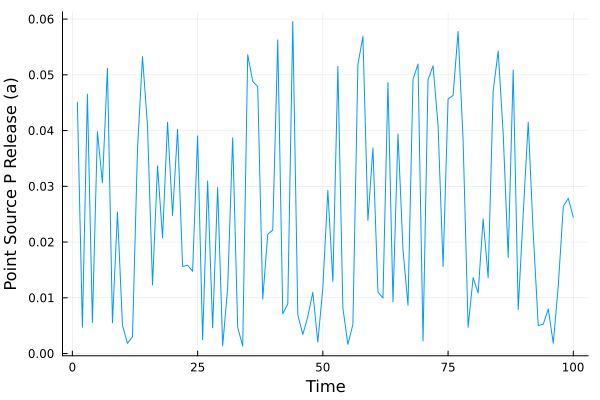

In [11]:
# plot the optimization result 
plot(1:100, x, legend = false,
xlabel = "Time", ylab = "Point Source P Release (a)")

### Problem 3 (3 points)

What did you learn about the use of these methods? Compare with your
experience with linear programming from earlier in the semester.



**Response:** After using these methods, I have learned several things. Firstly, I've learned that specifying the range of the decision space impacts your results; defining the problem is the problem. That is, how you formulate your problem can lead to drastically different results. In this lab, by incrementally changing things like the upper bound by a small amount such as 0.01, I got very different results. This tells me that when implementing any optimization problem, even though I got an "optimal solution" does not mean I got an optimal solution for the problem I am actually trying to solve. So, overall, using these methods made me realize that it is really important to try to formulate the problem to actually address your research questions of interest. Comparing my experiences with LPs earlier in the semester, I have realized that there are some cases where you might want to use an LP, whereas other cases you might not want to use an LP. If you are trying to force your problem to look like an LP just because they are relatively straightforward to solve, then that is not necessarily the best approach for problem solving. Using these methods from this lab made me realize that there are more powerful ways to solve non-linear problems, as opposed to trying to force the problem into an LP. But, I can see how these optimization approaches (such as what I experimented with here in this lab), can get computationally expensive relatively quickly, which is also something to consider when doing any sort of optimization.     

## References

Put any consulted sources here, including classmates you worked with/who
helped you.

Referenced the class slides. 